<a href="https://colab.research.google.com/github/fjadidi2001/Denoise/blob/main/Denoise_May18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up Environment



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installed Packages:
         Package       Version
0          torch   2.6.0+cu124
1    torchvision  0.21.0+cu124
2  opencv-python     4.11.0.86
3           h5py        3.13.0
4   scikit-image        0.25.2


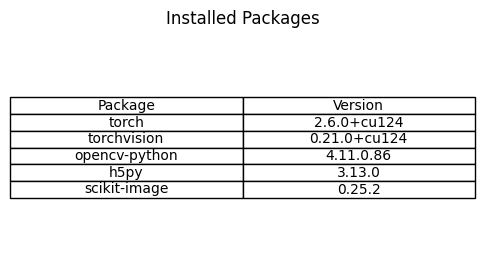

In [3]:
# Cell 1: Set Up Environment
from google.colab import drive
import os
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Install dependencies
!pip install torch torchvision opencv-python h5py scikit-image --quiet

# Create directories
base_dir = '/content/drive/MyDrive/SSNet'
os.makedirs(base_dir, exist_ok=True)
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/data/Kodak24', exist_ok=True)
os.makedirs(f'{base_dir}/logos', exist_ok=True)
os.makedirs(f'{base_dir}/saved_models', exist_ok=True)
os.makedirs(f'{base_dir}/ckpts', exist_ok=True)
os.makedirs(f'{base_dir}/output', exist_ok=True)

# Collect installed package versions
packages = ['torch', 'torchvision', 'opencv-python', 'h5py', 'scikit-image']
installed = {pkg: pkg_resources.get_distribution(pkg).version for pkg in packages}

# Create table
df = pd.DataFrame(list(installed.items()), columns=['Package', 'Version'])
print("Installed Packages:")
print(df)

# Plot table
plt.figure(figsize=(6, 3))
plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Installed Packages")
plt.savefig(f'{base_dir}/output/installed_packages.png')
plt.show()

# Download and Preprocess BSR Dataset



Dataset loaded successfully
Processing BSR dataset...
Dataset Statistics:
       Subset  Images  Patches  HDF5 Size (MB)
0       Train     200     1200      900.431168
1  Validation     100      100      176.735031
2        Test     200      200      353.470795


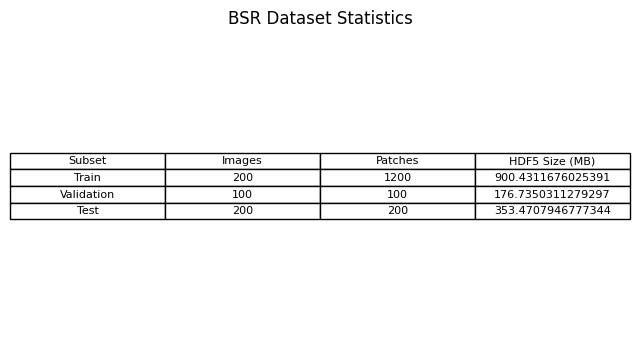

In [4]:
# Cell 2: Download and Preprocess BSR Dataset
import os
import glob
import cv2
import numpy as np
import h5py
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

# Download and extract BSR dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        !wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
    if not os.path.exists('BSR'):
        !tar xzf BSR_bsds500.tgz
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")

# Define data preparation function
def normalize(data):
    return data / 255.

def Im2Patch(img, win, stride=1):
    k = 0
    endc = img.shape[0]
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win, TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:, i:endw-win+i+1:stride, j:endh-win+j+1:stride]
            Y[:, k, :] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])

def prepare_data(data_path, bsr_root, patch_size=256, stride=128, aug_times=1, mode='color'):
    print('Processing BSR dataset...')
    scales = [1, 0.9, 0.8, 0.7]

    # Collect train, val, test images
    train_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/train', '*.jpg'))
    val_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/val', '*.jpg'))
    test_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/test', '*.jpg'))

    # Process training data
    h5f = h5py.File(os.path.join(data_path, 'train_color_right.h5'), 'w')
    train_num = 0
    for i in range(len(train_files)):
        img = cv2.imread(train_files[i])
        h, w, c = img.shape
        for k in range(len(scales)):
            if int(h * scales[k]) < 256 or int(w * scales[k]) < 256:
                continue
            Img = cv2.resize(img, (int(w * scales[k]), int(h * scales[k])), interpolation=cv2.INTER_CUBIC)
            Img = np.transpose(Img, (2, 0, 1))
            Img = np.float32(normalize(Img))
            patches = Im2Patch(Img, win=patch_size, stride=stride)
            for n in range(patches.shape[3]):
                data = patches[:, :, :, n].copy()
                h5f.create_dataset(str(train_num), data=data)
                train_num += 1
                for m in range(aug_times - 1):
                    data_aug = data_augmentation(data, np.random.randint(1, 8))
                    h5f.create_dataset(str(train_num) + "_aug_%d" % (m + 1), data=data_aug)
                    train_num += 1
    h5f.close()

    # Process validation data
    h5f = h5py.File(os.path.join(data_path, 'val_color_right.h5'), 'w')
    val_num = 0
    for i in range(len(val_files)):
        img = cv2.imread(val_files[i])
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(val_num), data=img)
        val_num += 1
    h5f.close()

    # Process test data (optional, for testing)
    h5f = h5py.File(os.path.join(data_path, 'test_color_right.h5'), 'w')
    test_num = 0
    for i in range(len(test_files)):
        img = cv2.imread(test_files[i])
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(test_num), data=img)
        test_num += 1
    h5f.close()

    # Collect statistics
    stats = {
        'Subset': ['Train', 'Validation', 'Test'],
        'Images': [len(train_files), len(val_files), len(test_files)],
        'Patches': [train_num, val_num, test_num],
        'HDF5 Size (MB)': [
            os.path.getsize(f'{data_path}/train_color_right.h5') / 1024**2,
            os.path.getsize(f'{data_path}/val_color_right.h5') / 1024**2,
            os.path.getsize(f'{data_path}/test_color_right.h5') / 1024**2
        ]
    }
    df = pd.DataFrame(stats)
    print("Dataset Statistics:")
    print(df)

    # Plot table
    plt.figure(figsize=(8, 4))
    plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title("BSR Dataset Statistics")
    plt.savefig(f'{base_dir}/output/dataset_stats.png')
    plt.show()

# Run preparation
prepare_data(f'{base_dir}/data', '.', patch_size=256, stride=128, aug_times=1, mode='color')

# Define Utility Functions and Dataset Class



Utility Functions:
                   Function                                        Description
0                seed_torch              Sets random seeds for reproducibility
1         data_augmentation  Applies augmentation (flips, rotations) to images
2       add_watermark_noise            Adds watermark noise to training images
3  add_watermark_noise_test                Adds watermark noise to test images


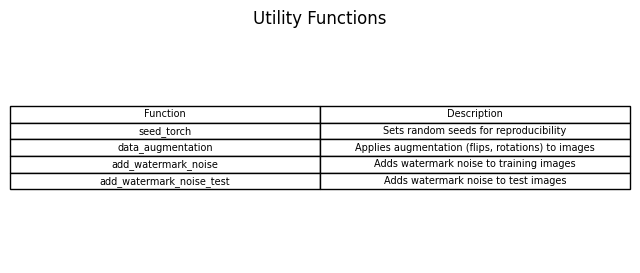

In [5]:
# Cell 3: Define Utility Functions and Dataset Class
import torch
import torch.utils.data as udata
import numpy as np
import random
import cv2
import string
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def data_augmentation(image, mode):
    out = np.transpose(image, (1, 2, 0))
    if mode == 0:
        out = out
    elif mode == 1:
        out = np.flipud(out)
    elif mode == 2:
        out = np.rot90(out)
    elif mode == 3:
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        out = np.rot90(out, k=2)
    elif mode == 5:
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        out = np.rot90(out, k=3)
    elif mode == 7:
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2, 0, 1))

def add_watermark_noise(img_train, scale_lists=None, idx_lists=None, is_test=False, threshold=50):
    watermarks = []
    logo_dir = f'{base_dir}/logos'
    for ii in range(12):
        logo_path = os.path.join(logo_dir, f'{ii+1:02d}.png')
        if os.path.exists(logo_path):
            watermarks.append(Image.open(logo_path))
        else:
            print(f"Warning: Logo {logo_path} not found")
            watermarks.append(Image.new('RGBA', (100, 100)))

    img_train = img_train.numpy()
    imgn_train = img_train.copy()
    _, _, img_h, img_w = img_train.shape
    img_train = np.transpose(img_train, (0, 2, 3, 1))
    imgn_train = np.transpose(imgn_train, (0, 2, 3, 1))
    ans_scale_lists = scale_lists if scale_lists else []
    ans_idx_lists = idx_lists if idx_lists else []

    for i in range(len(img_train)):
        tmp = Image.fromarray((img_train[i] * 255).astype(np.uint8))
        img_for_cnt = Image.fromarray(np.zeros((img_h, img_w, 3), np.uint8))

        if scale_lists is None:
            scale_list = []
            idx = random.randint(0, len(watermarks)-1)
            ans_idx_lists.append(idx)
            watermark = watermarks[idx]
            w, h = watermark.size
            mark_size = np.array(watermark).size
            occupancy = threshold if is_test else np.random.uniform(0, 10)
            cnt, ratio = 0, img_w * img_h * 3 * occupancy / 100
            finish = False
            while True:
                if (ratio - cnt) < mark_size * 0.3:
                    img_train[i] = np.array(tmp).astype(np.float64) / 255.
                    break
                elif (ratio - cnt) < mark_size:
                    scale = (ratio - cnt) * 1.0 / mark_size
                    finish = True
                else:
                    scale = np.random.uniform(0.5, 1)
                scale_list.append(scale)

                water = watermark.resize((int(w * scale), int(h * scale)))
                x = random.randint(0, img_w - int(w * scale))
                y = random.randint(0, img_h - int(h * scale))
                tmp.paste(water, (x, y), water)
                img_for_cnt.paste(water, (x, y), water)
                img_cnt = np.array(img_for_cnt)
                cnt = (img_cnt > 0).sum()
                if finish:
                    img_train[i] = np.array(tmp).astype(np.float64) / 255.
                    break
            ans_scale_lists.append(scale_list)
        else:
            scale_list = scale_lists[i]
            idx = idx_lists[i]
            watermark = watermarks[idx]
            w, h = watermark.size
            for ii in range(len(scale_list)):
                scale = scale_list[ii]
                water = watermark.resize((int(w * scale), int(h * scale)))
                x = random.randint(0, img_w - int(w * scale))
                y = random.randint(0, img_h - int(h * scale))
                tmp.paste(water, (x, y), water)
            img_train[i] = np.array(tmp).astype(np.float64) / 255.

    img_train = np.transpose(img_train, (0, 3, 1, 2))
    imgn_train = np.transpose(imgn_train, (0, 3, 1, 2))
    return img_train, img_train - imgn_train, ans_scale_lists, ans_idx_lists

def add_watermark_noise_test(img, num_wm=1):
    watermarks = []
    logo_dir = f'{base_dir}/logos'
    for ii in range(12):
        logo_path = os.path.join(logo_dir, f'{ii+1:02d}.png')
        if os.path.exists(logo_path):
            watermarks.append(Image.open(logo_path))
        else:
            watermarks.append(Image.new('RGBA', (100, 100)))

    img = img.numpy()
    imgn = img.copy()
    _, _, img_h, img_w = img.shape
    img = np.transpose(img, (0, 2, 3, 1))
    imgn = np.transpose(imgn, (0, 2, 3, 1))

    for i in range(len(img)):
        tmp = Image.fromarray((img[i] * 255).astype(np.uint8))
        idx = random.randint(0, len(watermarks)-1)
        watermark = watermarks[idx]
        w, h = watermark.size
        for ii in range(num_wm):
            scale = np.random.uniform(0.5, 1)
            water = watermark.resize((int(w * scale), int(h * scale)))
            x = random.randint(0, img_w - int(w * scale))
            y = random.randint(0, img_h - int(h * scale))
            tmp.paste(water, (x, y), water)
        img[i] = np.array(tmp).astype(np.float64) / 255.

    img = np.transpose(img, (0, 3, 1, 2))
    imgn = np.transpose(imgn, (0, 3, 1, 2))
    return img, img - imgn

# Custom BSR dataset class for HDF5
class BSRDataset(udata.Dataset):
    def __init__(self, data_path, train=True):
        super(BSRDataset, self).__init__()
        self.train = train
        h5f = h5py.File(os.path.join(data_path, 'train_color_right.h5' if train else 'val_color_right.h5'), 'r')
        self.keys = list(h5f.keys())
        random.shuffle(self.keys)
        h5f.close()
        self.data_path = data_path

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        h5f = h5py.File(os.path.join(self.data_path, 'train_color_right.h5' if self.train else 'val_color_right.h5'), 'r')
        key = self.keys[index]
        data = np.array(h5f[key])
        h5f.close()
        return torch.Tensor(data)

# Table of utility functions
utils = {
    'Function': ['seed_torch', 'data_augmentation', 'add_watermark_noise', 'add_watermark_noise_test'],
    'Description': [
        'Sets random seeds for reproducibility',
        'Applies augmentation (flips, rotations) to images',
        'Adds watermark noise to training images',
        'Adds watermark noise to test images'
    ]
}
df = pd.DataFrame(utils)
print("Utility Functions:")
print(df)

# Plot table
plt.figure(figsize=(8, 3))
plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Utility Functions")
plt.savefig(f'{base_dir}/output/utility_functions.png')
plt.show()

# Define Model and Loss



Model Architecture Summary (First 10 Layers):
          Layer  Parameters
0  _block1_dw.0        1344
1  _block1_dw.1           0
2  _block1_dw.2       20784
3  _block1_dw.3           0
4  _block1_dw.4           0
5  _block2_dw.0       20784
6  _block2_dw.1           0
7  _block2_dw.2           0
8  _block3_dw.0       20784
9  _block3_dw.1           0


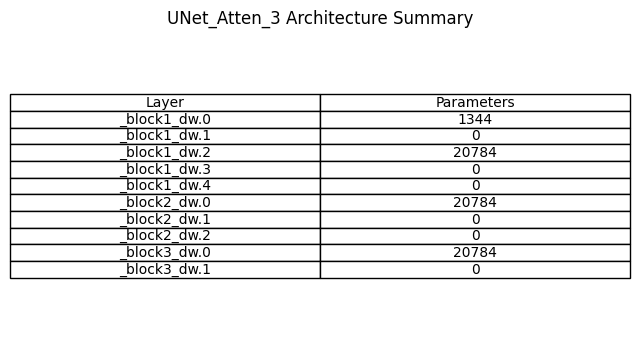

In [6]:
# Cell 4: Define Model and Loss
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss  # Import _Loss
import pandas as pd
import matplotlib.pyplot as plt

class sum_squared_error(_Loss):
    def __init__(self, size_average=None, reduce=None, reduction='sum'):
        super(sum_squared_error, self).__init__(size_average, reduce, reduction)

    def forward(self, input, target):
        return torch.nn.functional.mse_loss(input, target, size_average=None, reduce=None, reduction='sum').div_(2)

class UNet_Atten_3(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNet_Atten_3, self).__init__()
        self._block1_dw = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_dw = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_dw = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_dw = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_dw = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_dw = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._block1_dw2 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_dw2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_dw2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_dw2 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_dw2 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_dw2 = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._block1_dn = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_dn = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_dn = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_dn = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_dn = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_dn = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._block1_wm = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block2_wm = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))
        self._block3_wm = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
        self._block4_wm = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block5_wm = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1))
        self._block6_wm = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self.avg_dn = nn.AdaptiveAvgPool2d((1, 1))
        self.attn_dn = nn.Sequential(
            nn.Conv2d(144, 6, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 144, kernel_size=1, stride=1),
            nn.Sigmoid())
        self.avg_wm = nn.AdaptiveAvgPool2d((1, 1))
        self.attn_wm = nn.Sequential(
            nn.Conv2d(144, 6, kernel_size=1, stride=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(6, 144, kernel_size=1, stride=1),
            nn.Sigmoid())
        self.out = nn.Sequential(
            nn.Conv2d(out_channels * 2, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1))
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        pool1_dn = self._block1_dn(x)
        pool2_dn = self._block2_dn(pool1_dn)
        pool3_dn = self._block2_dn(pool2_dn)
        pool4_dn = self._block2_dn(pool3_dn)
        pool5_dn = self._block2_dn(pool4_dn)
        upsample5_dn = self._block3_dn(pool5_dn)
        concat5_dn = torch.cat((upsample5_dn, pool4_dn), dim=1)
        upsample4_dn = self._block4_dn(concat5_dn)
        concat4_dn = torch.cat((upsample4_dn, pool3_dn), dim=1)
        upsample3_dn = self._block5_dn(concat4_dn)
        concat3_dn = torch.cat((upsample3_dn, pool2_dn), dim=1)
        upsample2_dn = self._block5_dn(concat3_dn)
        concat2_dn = torch.cat((upsample2_dn, pool1_dn), dim=1)
        upsample1_dn = self._block5_dn(concat2_dn)
        concat1_dn = torch.cat((upsample1_dn, x), dim=1)
        out_denoise = self._block6_dn(concat1_dn)

        pool1_wm = self._block1_wm(out_denoise)
        pool2_wm = self._block2_wm(pool1_wm)
        pool3_wm = self._block2_wm(pool2_wm)
        pool4_wm = self._block2_wm(pool3_wm)
        pool5_wm = self._block2_wm(pool4_wm)
        upsample5_wm = self._block3_wm(pool5_wm)
        concat5_wm = torch.cat((upsample5_wm, pool4_wm), dim=1)
        upsample4_wm = self._block4_wm(concat5_wm)
        concat4_wm = torch.cat((upsample4_wm, pool3_wm), dim=1)
        upsample3_wm = self._block5_wm(concat4_wm)
        concat3_wm = torch.cat((upsample3_wm, pool2_wm), dim=1)
        upsample2_wm = self._block5_wm(concat3_wm)
        concat2_wm = torch.cat((upsample2_wm, pool1_wm), dim=1)
        upsample1_wm = self._block5_wm(concat2_wm)
        concat1_wm = torch.cat((upsample1_wm, x), dim=1)
        out_wm = self._block6_wm(concat1_wm)

        pool1_dw = self._block1_dw(x)
        pool2_dw = self._block2_dw(pool1_dw)
        pool3_dw = self._block2_dw(pool2_dw)
        pool4_dw = self._block2_dw(pool3_dw)
        pool5_dw = self._block2_dw(pool4_dw)
        upsample5_dw = self._block3_dw(pool5_dw)
        concat5_dw = torch.cat((upsample5_dw, pool4_dw), dim=1)
        upsample4_dw = self._block4_dw(concat5_dw)
        concat4_dw = torch.cat((upsample4_dw, pool3_dw), dim=1)
        upsample3_dw = self._block5_dw(concat4_dw)
        concat3_dw = torch.cat((upsample3_dw, pool2_dw), dim=1)
        upsample2_dw = self._block5_dw(concat3_dw)
        concat2_dw = torch.cat((upsample2_dw, pool1_dw), dim=1)
        mid_dn = self.avg_dn(concat2_dn)
        Scale_dn = self.attn_dn(mid_dn)
        concat2_dw = concat2_dw * Scale_dn
        upsample1_dw = self._block5_dw(concat2_dw)
        concat1_dw = torch.cat((upsample1_dw, x), dim=1)
        main_out_mid = self._block6_dw(concat1_dw)

        pool1_dw2 = self._block1_dw2(main_out_mid)
        pool2_dw2 = self._block2_dw2(pool1_dw2)
        pool3_dw2 = self._block2_dw2(pool2_dw2)
        pool4_dw2 = self._block2_dw(pool3_dw2)
        pool5_dw2 = self._block2_dw(pool4_dw2)
        upsample5_dw2 = self._block3_dw(pool5_dw2)
        concat5_dw2 = torch.cat((upsample5_dw2, pool4_dw2), dim=1)
        upsample4_dw2 = self._block4_dw(concat5_dw2)
        concat4_dw2 = torch.cat((upsample4_dw2, pool3_dw2), dim=1)
        upsample3_dw2 = self._block5_dw(concat4_dw2)
        concat3_dw2 = torch.cat((upsample3_dw2, pool2_dw2), dim=1)
        upsample2_dw2 = self._block5_dw(concat3_dw2)
        concat2_dw2 = torch.cat((upsample2_dw2, pool1_dw2), dim=1)
        mid_wm = self.avg_wm(concat2_wm)
        Scale_wm = self.attn_wm(mid_wm)
        concat2_dw2 = concat2_dw2 * Scale_wm
        upsample1_dw2 = self._block5_dw2(concat2_dw2)
        concat1_dw2 = torch.cat((upsample1_dw2, x), dim=1)
        main_out_final = self._block6_dw2(concat1_dw2)

        return main_out_final, out_denoise, out_wm

# Summarize model architecture
model = UNet_Atten_3()
layers = []
params = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.MaxPool2d, nn.ReLU, nn.LeakyReLU, nn.AdaptiveAvgPool2d)):
        layers.append(name)
        param_count = sum(p.numel() for p in module.parameters())
        params.append(param_count)

# Create table
df = pd.DataFrame({'Layer': layers[:10], 'Parameters': params[:10]})  # Show first 10 for brevity
print("Model Architecture Summary (First 10 Layers):")
print(df)

# Plot table
plt.figure(figsize=(8, 4))
plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("UNet_Atten_3 Architecture Summary")
plt.savefig(f'{base_dir}/output/model_architecture.png')
plt.show()

# Train the Model

Loading dataset...
# of training samples: 1200
Loaded checkpoint from epoch 6
Epoch 7, Loss: 2481.4754, Time: 157.40s
Epoch 8, Loss: 1831.9597, Time: 148.98s
Epoch 9, Loss: 1846.6891, Time: 148.89s


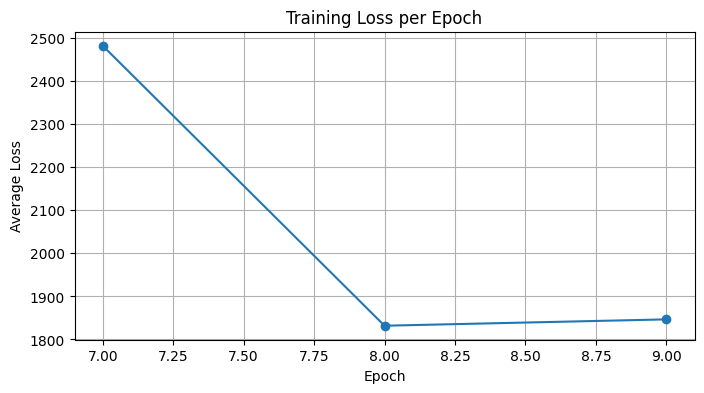

In [7]:
# Cell 5: Train the Model
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR  # Added import for StepLR
import time
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob

# Define base_dir (ensure consistency with previous cells)
base_dir = '/content/drive/MyDrive/SSNet'

def findLastCheckpoint(save_path):
    files = glob.glob(os.path.join(save_path, '*.pth'))
    last_epoch = -1
    for fi in files:
        try:
            epoch = int(os.path.basename(fi)[-7:-4])
            if last_epoch < epoch:
                last_epoch = epoch
        except ValueError:
            continue
    return last_epoch

def train():
    class Args:
        model_name = 'MyModel'
        data_path = f'{base_dir}/data'
        batchSize = 8  # Reduced from 16 to avoid CUDA out-of-memory
        epochs = 10  # Reduced for demo; increase to 90 for full training
        lr = 1e-3
        outf = f'{base_dir}/saved_models'

    opt = Args()

    print('Loading dataset...')
    try:
        dataset_train = BSRDataset(opt.data_path, train=True)
        dataset_val = BSRDataset(opt.data_path, train=False)
        loader_train = DataLoader(dataset=dataset_train, num_workers=2, batch_size=opt.batchSize, shuffle=True)
        print(f"# of training samples: {len(dataset_train)}")
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return

    model = UNet_Atten_3()
    criterion = sum_squared_error()
    model = nn.DataParallel(model).cuda()
    criterion = criterion.cuda()

    optimizer = optim.Adam(model.parameters(), lr=opt.lr)
    scheduler = StepLR(optimizer, step_size=30, gamma=0.2)

    save_path = os.path.join(opt.outf, opt.model_name)
    os.makedirs(save_path, exist_ok=True)
    initial_epoch = findLastCheckpoint(save_path)
    if initial_epoch != -1:
        try:
            model.load_state_dict(torch.load(os.path.join(save_path, f'{opt.model_name}{initial_epoch:03d}.pth')))
            print(f"Loaded checkpoint from epoch {initial_epoch}")
        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            initial_epoch = -1
    initial_epoch += 1

    losses = []
    noiseL_B = [0, 55]
    for epoch in range(initial_epoch, opt.epochs):
        start_time = time.time()
        epoch_loss = 0
        model.train()
        for i, data in enumerate(loader_train, 0):
            optimizer.zero_grad()
            img_train = data
            noise_gauss = torch.zeros(img_train.size())
            stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise_gauss.size()[0])
            for n in range(noise_gauss.size()[0]):
                sizeN = noise_gauss[0, :, :, :].size()
                noise_gauss[n, :, :, :] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n]/255.)

            noise_gauss_mid = torch.zeros(img_train.size())
            stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise_gauss_mid.size()[0])
            for n in range(noise_gauss_mid.size()[0]):
                sizeN = noise_gauss_mid[0, :, :, :].size()
                noise_gauss_mid[n, :, :, :] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n]/255.)

            noise_final_gauss = torch.zeros(img_train.size())
            stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise_final_gauss.size()[0])
            for n in range(noise_final_gauss.size()[0]):
                sizeN = noise_final_gauss[0, :, :, :].size()
                noise_final_gauss[n, :, :, :] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n]/255.)

            try:
                imgn_train, wm, scale_lists, idx_lists = add_watermark_noise(img_train)
                imgn_train_final_, wm_final, _, _ = add_watermark_noise(img_train, scale_lists, idx_lists)
            except Exception as e:
                print(f"Error adding watermark noise: {e}")
                continue

            imgn_train_mid = torch.Tensor(imgn_train) + noise_gauss_mid
            imgn_train = torch.Tensor(imgn_train) + noise_gauss
            imgn_train_final_ = torch.Tensor(imgn_train_final_)
            imgn_train_final = imgn_train_final_ + noise_final_gauss

            img_train, imgn_train = img_train.cuda(), imgn_train.cuda()
            imgn_train_final, imgn_train_mid = imgn_train_final.cuda(), imgn_train_mid.cuda()
            imgn_train_final_ = imgn_train_final_.cuda()

            try:
                main_out_final, out_denoise, out_wm = model(imgn_train)
                loss = (criterion(main_out_final, imgn_train_final) +
                        criterion(out_denoise, imgn_train_mid) +
                        criterion(out_wm, imgn_train_final_)) / (imgn_train.size()[0] * 2)

                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            except RuntimeError as e:
                print(f"Runtime error during training: {e}")
                continue

        scheduler.step()
        avg_loss = epoch_loss / len(loader_train)
        losses.append(avg_loss)
        print(f'Epoch {epoch}, Loss: {avg_loss:.4f}, Time: {time.time()-start_time:.2f}s')

        try:
            torch.save(model.state_dict(), os.path.join(save_path, f'{opt.model_name}{epoch:03d}.pth'))
        except Exception as e:
            print(f"Error saving checkpoint: {e}")

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(range(initial_epoch, opt.epochs), losses, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss per Epoch')
    plt.grid(True)
    plt.savefig(f'{base_dir}/output/training_loss.png')
    plt.show()

# Run training
try:
    train()
except Exception as e:
    print(f"Training failed: {e}")

# Test the Model



Loading checkpoint: /content/drive/MyDrive/SSNet/saved_models/MyModel/MyModel009.pth (epoch 9)
Test Metrics:
   Noise Level  Watermark Count       PSNR      SSIM
0           15                1  30.801038  0.878483
1           15                2  30.725621  0.879979
2           15                4  30.589105  0.882556
3           25                1  28.623625  0.804109
4           25                2  28.590482  0.805929
5           25                4  28.490674  0.810288
6           50                1  25.085929  0.639914
7           50                2  25.041504  0.643544
8           50                4  24.961671  0.650801


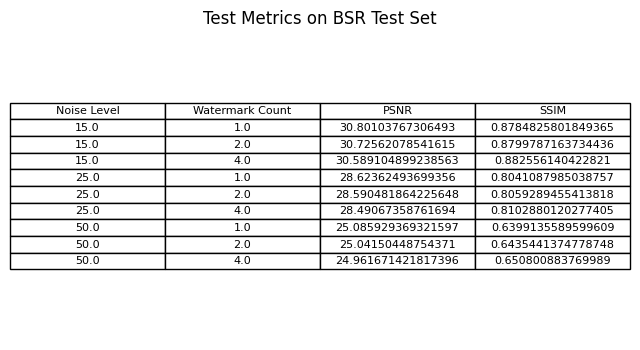

In [9]:
# Cell 6: Test the Model
import glob
import os
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Define base_dir
base_dir = '/content/drive/MyDrive/SSNet'

def find_latest_checkpoint(save_path):
    files = glob.glob(os.path.join(save_path, '*.pth'))
    if not files:
        return None, -1
    latest_epoch = -1
    latest_file = None
    for fi in files:
        try:
            epoch = int(os.path.basename(fi)[-7:-4])
            if epoch > latest_epoch:
                latest_epoch = epoch
                latest_file = fi
        except ValueError:
            continue
    return latest_file, latest_epoch

def test():
    class Args:
        ckpt_dir = f'{base_dir}/saved_models/MyModel'  # Changed to saved_models/MyModel
        test_data = 'BSR_test'
        test_dir = f'{base_dir}/data'
        test_noiseL = [15, 25, 50]
        wm_num = [1, 2, 4]

    opt = Args()

    # Find latest checkpoint
    checkpoint_path, epoch = find_latest_checkpoint(opt.ckpt_dir)
    if checkpoint_path is None:
        print(f"No checkpoints found in {opt.ckpt_dir}")
        return

    print(f"Loading checkpoint: {checkpoint_path} (epoch {epoch})")

    # Build model
    net = UNet_Atten_3()
    model = nn.DataParallel(net).cuda()
    try:
        model.load_state_dict(torch.load(checkpoint_path))
    except Exception as e:
        print(f"Error loading checkpoint {checkpoint_path}: {e}")
        return
    model.eval()

    # Load test dataset
    try:
        dataset_test = BSRDataset(opt.test_dir, train=False)
        loader_test = DataLoader(dataset=dataset_test, batch_size=1, shuffle=False)
    except Exception as e:
        print(f"Error loading test dataset: {e}")
        return

    adjust = 32
    results = []

    for noise_level in opt.test_noiseL:
        for wm_num in opt.wm_num:
            psnr_test, ssim_test = 0, 0
            valid_num = 0
            for data in loader_test:
                valid_num += 1
                ISource = data
                noise_gs = torch.FloatTensor(ISource.size()).normal_(mean=0, std=noise_level/255.)
                INoisy, _ = add_watermark_noise_test(ISource, num_wm=wm_num)
                INoisy = torch.Tensor(INoisy) + noise_gs
                ISource, INoisy = ISource.cuda(), INoisy.cuda()

                _, _, w, h = ISource.shape
                w_new = int(int(w / adjust) * adjust)
                h_new = int(int(h / adjust) * adjust)
                Result = INoisy.clone()

                with torch.no_grad():
                    Out = model(INoisy[:, :, :w_new, :h_new])[0]
                    Result[:, :, 0:w_new, 0:h_new] = Out

                Result = torch.clamp(Result, 0., 1.)
                INoisy = torch.clamp(INoisy, 0., 1.)

                result = np.transpose(Result[0, :, :, :].cpu().numpy(), (1, 2, 0))
                result2 = np.transpose(ISource[0, :, :, :].cpu().numpy(), (1, 2, 0))
                psnr_x = peak_signal_noise_ratio(result, result2, data_range=1)
                ssim_x = structural_similarity(result, result2, channel_axis=2, data_range=1)
                psnr_test += psnr_x
                ssim_test += ssim_x

                output_dir = f'{base_dir}/output/{opt.test_data}'
                os.makedirs(output_dir, exist_ok=True)
                output_path = os.path.join(output_dir, f'result_{valid_num}_noise{noise_level}_wm{wm_num}.png')
                cv2.imwrite(output_path, (result * 255).astype(np.uint8))

            psnr_test /= valid_num
            ssim_test /= valid_num
            results.append({
                'Noise Level': noise_level,
                'Watermark Count': wm_num,
                'PSNR': psnr_test,
                'SSIM': ssim_test
            })

    # Create table
    df = pd.DataFrame(results)
    print("Test Metrics:")
    print(df)

    # Plot table
    plt.figure(figsize=(8, 4))
    plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title("Test Metrics on BSR Test Set")
    plt.savefig(f'{base_dir}/output/test_metrics.png')
    plt.show()

# Run test
test()

In [18]:
# Cell 7: Visualize Results
import torchvision.transforms as transforms
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import pandas as pd
import matplotlib.pyplot as plt
import torch
from PIL import Image
import numpy as np
import os

# Define base_dir
base_dir = '/content/drive/MyDrive/SSNet'

# Load sample image
image_path = 'BSR/BSDS500/data/images/test/100007.jpg'
try:
    original_image = Image.open(image_path).convert('RGB')
except FileNotFoundError:
    print(f"Image not found: {image_path}")
    raise

np_image_rgb = np.array(original_image)

# Add noise and watermark
sigma = 25
num_wm = 1
print(f"num_wm type: {type(num_wm)}, value: {num_wm}")  # Debug
original_tensor = transforms.ToTensor()(original_image).unsqueeze(0)
try:
    noisy_image, _ = add_watermark_noise_test(original_tensor, num_wm=num_wm)
except Exception as e:
    print(f"Error in add_watermark_noise_test: {e}")
    raise
noisy_image = noisy_image + torch.normal(0, sigma/255., noisy_image.size())
noisy_image = torch.clamp(noisy_image, 0., 1.)
noisy_image_rgb = np.transpose(noisy_image[0].numpy(), (1, 2, 0)) * 255
noisy_image_pil = Image.fromarray(noisy_image_rgb.astype(np.uint8))

# Denoise with model
model = UNet_Atten_3()
model = nn.DataParallel(model).cuda()
checkpoint_path = f'{base_dir}/saved_models/MyModel/MyModel009.pth'  # Updated to match Cell 6
try:
    model.load_state_dict(torch.load(checkpoint_path))
except FileNotFoundError:
    print(f"Checkpoint not found: {checkpoint_path}")
    raise
model.eval()
with torch.no_grad():
    denoised_tensor = model(noisy_image.cuda())[0]
denoised_image = torch.clamp(denoised_tensor, 0., 1.)
denoised_image_rgb = np.transpose(denoised_image.cpu().numpy(), (1, 2, 0)) * 255
denoised_image_pil = Image.fromarray(denoised_image_rgb.astype(np.uint8))

# Compute metrics
psnr_noisy = peak_signal_noise_ratio(np_image_rgb, noisy_image_rgb, data_range=255)
ssim_noisy = structural_similarity(np_image_rgb, noisy_image_rgb, channel_axis=2, data_range=255)
psnr_denoised = peak_signal_noise_ratio(np_image_rgb, denoised_image_rgb, data_range=255)
ssim_denoised = structural_similarity(np_image_rgb, denoised_image_rgb, channel_axis=2, data_range=255)

# Create metrics table
metrics = pd.DataFrame({
    'Stage': ['Noisy', 'Denoised'],
    'PSNR': [psnr_noisy, psnr_denoised],
    'SSIM': [ssim_noisy, ssim_denoised]
})

# Visualize
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(original_image)
plt.title('Original')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(noisy_image_pil)
plt.title(f'Noisy (σ={sigma}, WM={num_wm})')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(denoised_image_pil)
plt.title('Denoised')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.table(cellText=metrics.values, colLabels=metrics.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Metrics")
plt.savefig(f'{base_dir}/output/result_comparison.png')
plt.show()

num_wm type: <class 'int'>, value: 1


TypeError: 'int' object is not callable